Some data was collected prior writing this report. For example,
`./data/sites_published` has the output `aws s3 ls` for the `publisherstore-us`
bucket that contains archives of the published websites. In addition,
`./data/sites_to_copy.csv` contains site ids that needs to be republished. At
the moment, SQL query for them looks like that:

```sql
select distinct sps.id
from sites_publishedsite sps
		 join (select *
			   from sites_sitereplicant outer_
			   where not exists(select 1
								from sites_sitereplicant inner_
								where inner_.id = outer_.id
								  and inner_.store_id in %s)) ssr
			  on ssr.published_site_id = sps.id
		where sps.disabled = 0
			and sps.state = 0
			and date_published >= DATE '2018-08-01'
```

Let's prepare our data. We will select ZIP files from the bucket.

In [182]:
!pv ./data/sites_published | grep .zip | \
	awk '{gsub(".zip$", "", $4);print $4}' > \
	./data/transformed/sites_published_zips.csv

 773MiB 0:00:22 [34.9MiB/s] [================================>] 100%            


Here is how look ids of the sites that we need to copy

In [157]:
import pandas as pd
sites_to_copy = pd.read_csv(
	'./data/sites_to_copy.csv', names=['site_to_copy_ids'])
sites_to_copy.head()

,site_to_copy_ids
0,0000201ae82e4b1293c860235894200f
1,00003b1c0f064827bdc7e0397139dc93
2,000047159c254c06848660d03a72f038
3,00008a6f271548ff9a6274620c7bd6cc
4,0000a6c1778a44d1a0687266a94f00a9


There are plenty of them:

In [158]:
sites_to_copy.count()

site_to_copy_ids    359165
dtype: int64

Here is how look ids of the artifacts in the S3

In [159]:
sites_published_zips = pd.read_csv(
	'./data/transformed/sites_published_zips.csv',
	names=['site_published_zips'])
sites_published_zips.head()

,site_published_zips
0,00001f94c5c54973b5539aca547f48cf
1,0000201ae82e4b1293c860235894200f
2,0000237a29ef4155a731cac18e3425a5
3,0000252074964f219d47ea136ffef019
4,00002f6e7c274081873af579c80e3a25


Is there any site without an archive?

In [160]:
diff = set(sites_to_copy['site_to_copy_ids'].values.tolist()).difference(
	set(sites_published_zips['site_published_zips'].values.tolist()))


print(bool(diff))

True


Really? Give an example please.

In [181]:
import random
random.sample(diff, 10)

['c1cfd45b9a08494f9cfe5123954e7a52',
 'e01d91d9d61b4d70a8a73c86aab47ff7',
 '4489c8217559412d970e2293ff869dd3',
 '672e4249f6b44d469c961becf98438b8',
 '223c1cb926594fe08aced914153a6c71',
 '44ba64233b204ed6a9221aa3413cebe1',
 '09c6459508ca49419692a032a8683722',
 'ed331420cdf1486f92d74768e1fd81bf',
 '615bfba479704c659a7f42a5b6856663',
 'f716eb3de23d4c1cafd17466679b8142']

How many?

In [162]:
print('Total: %s' % len(diff))

Total: 10673


Ok, let's prepare our data, but this time we will include object
 creation date.

In [163]:
!pv ./data/sites_published | grep .zip | \
	awk '{gsub(".zip$", "" ,$4); print $4 "," $1 "T" $2 "Z"}' > \
	./data/transformed/sites_published_zips_with_dates.csv

 773MiB 0:00:26 [29.1MiB/s] [================================>] 100%            


Archives and their creation dates(a-la CSV).

In [164]:
!head -n 5 ./data/transformed/sites_published_zips_with_dates.csv

00001f94c5c54973b5539aca547f48cf,2016-03-09T19:07:12Z
0000201ae82e4b1293c860235894200f,2020-10-05T06:02:05Z
0000237a29ef4155a731cac18e3425a5,2017-11-07T05:16:45Z
0000252074964f219d47ea136ffef019,2016-06-23T07:29:33Z
00002f6e7c274081873af579c80e3a25,2015-11-05T21:27:35Z


Sites and their publishing dates(CSV).

In [165]:
!head -n 5 ./data/sites_to_copy_with_dates.csv

0000201ae82e4b1293c860235894200f,2020-10-05T06:02:04Z
00003b1c0f064827bdc7e0397139dc93,2019-05-26T06:45:48Z
000047159c254c06848660d03a72f038,2020-02-14T17:07:26Z
00008a6f271548ff9a6274620c7bd6cc,2020-05-14T21:40:34Z
0000a6c1778a44d1a0687266a94f00a9,2019-01-23T17:21:25Z


In [166]:
sites_to_copy_with_dates = pd.read_csv(
	'./data/sites_to_copy_with_dates.csv',
	names=['site_to_copy_ids', 'site_published_date'],
	parse_dates=['site_published_date']
).set_index('site_to_copy_ids')

In [167]:
sites_published_zips_with_dates = pd.read_csv(
	'./data/transformed/sites_published_zips_with_dates.csv',
	names=['site_published_zips_ids', 's3_object_published_date'],
	parse_dates=['s3_object_published_date']
).set_index('site_published_zips_ids')

We can join sites and archives on id

In [168]:
dates_joined = sites_to_copy_with_dates.join(
	sites_published_zips_with_dates, lsuffix='l_', rsuffix='r_')
dates_joined.head()

,site_published_date,s3_object_published_date
site_to_copy_ids,,
0000201ae82e4b1293c860235894200f,2020-10-05 06:02:04+00:00,2020-10-05 06:02:05+00:00
00003b1c0f064827bdc7e0397139dc93,2019-05-26 06:45:48+00:00,2019-05-26 06:45:49+00:00
000047159c254c06848660d03a72f038,2020-02-14 17:07:26+00:00,2020-02-14 17:07:26+00:00
00008a6f271548ff9a6274620c7bd6cc,2020-05-14 21:40:34+00:00,2020-05-14 21:40:35+00:00
0000a6c1778a44d1a0687266a94f00a9,2019-01-23 17:21:25+00:00,2019-01-23 17:21:25+00:00


Let's calculate the timedelta between two publishing dates.

In [169]:
dates_joined['timedelta'] = (dates_joined['s3_object_published_date']
	- dates_joined['site_published_date'])

In [170]:
dates_joined.sort_values('timedelta')

,site_published_date,s3_object_published_date,timedelta
site_to_copy_ids,,,
8a49866b2966498601298fd5da6f26c9,2020-11-18 13:55:26+00:00,2010-09-04 21:18:15+00:00,-3728 days +07:22:49
8a49866b2a910c98012a96734c144cbe,2020-11-18 13:55:48+00:00,2010-09-09 17:10:09+00:00,-3723 days +03:14:21
8a49866a2af939b8012afaf34d3a118c,2020-11-18 13:43:41+00:00,2010-09-10 10:01:53+00:00,-3723 days +20:18:12
8a49866a2afe125c012b094dfba27d42,2020-11-11 12:41:20+00:00,2010-09-13 05:19:18+00:00,-3713 days +16:37:58
8a4986cb2b8aa1a7012b9b38f7121aa7,2020-11-18 13:56:03+00:00,2010-10-11 12:17:31+00:00,-3692 days +22:21:28
...,...,...,...
ffefac401f764344be62136a24762b2b,2019-03-21 17:56:01+00:00,NaT,NaT
fff25cfce17b4ef1944e9a5ffa7c158f,2019-03-25 20:49:20+00:00,NaT,NaT
fff2f61e5b9e4306a7d078ad2f4982b6,2020-11-09 11:15:17+00:00,NaT,NaT


In [171]:
no_na = dates_joined.sort_values('timedelta').dropna()
short_discrepancy = no_na[(no_na['timedelta'] > pd.Timedelta(days=1))
	  | (no_na['timedelta'] < pd.Timedelta(days=-1))]

How many sites have publishing date discrepancy with their S3 object?
Also, exclude sites that miss archive completely.

In [172]:
short_discrepancy.count()

site_published_date         7065
s3_object_published_date    7065
timedelta                   7065
dtype: int64

In [173]:
import matplotlib.pyplot as plt
%matplotlib inline

In [174]:
discrepancy_dates = short_discrepancy.apply(
	lambda row: row.site_published_date.date(), axis='columns')

In [175]:
discrepancy_dates.value_counts()
pass

Show please when happened discrepancies between site publish data and S3 object
 creation timestamp.

<AxesSubplot:xlabel='Date', ylabel='Discrepancy Publish Count'>

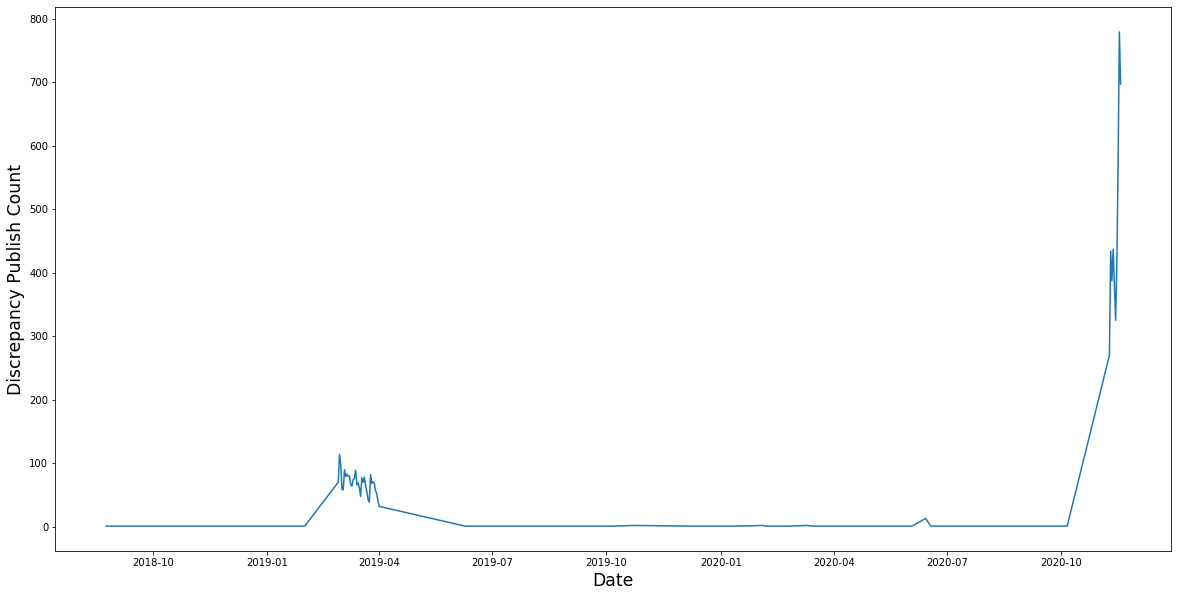

In [176]:
plt.figure(figsize=(20, 10))
plt.xlabel('Date', **{'fontsize': 'xx-large'})
plt.ylabel('Discrepancy Publish Count', **{'fontsize': 'xx-large'})
discrepancy_dates.value_counts().plot()

Now let's find more info about the absent artifacts. Show please the count of
 site with absent artifacts per site publishing date.

In [177]:
absent_values = dates_joined[
	dates_joined['s3_object_published_date'].isna()
	& (dates_joined['site_published_date'] < pd.Timestamp(
		'2020-11-01T00:00Z'))]
absent_dates = absent_values.apply(
	lambda row: row.site_published_date.date(), axis='columns'
)
absent_dates.value_counts()
pass

<AxesSubplot:xlabel='Date', ylabel='Count of absent artifacts'>

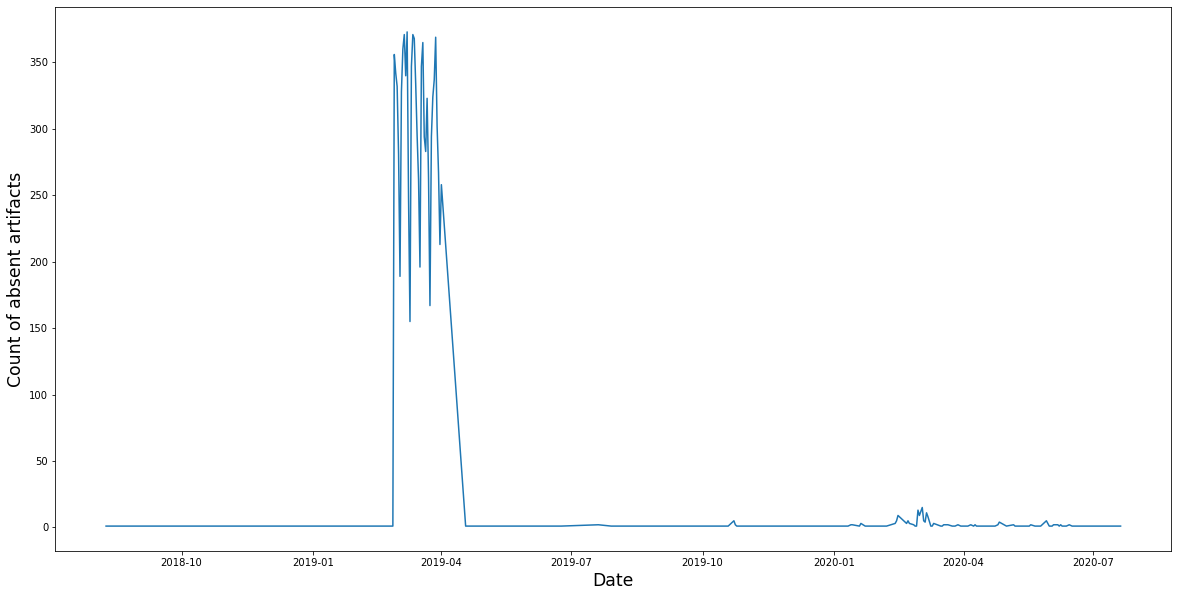

In [185]:
plt.figure(figsize=(20, 10))
plt.xlabel('Date', **{'fontsize': 'xx-large'})
plt.ylabel('Count of absent artifacts', **{'fontsize': 'xx-large'})
absent_dates.value_counts().plot()

The same plot, but Y-axis log scale, please?

<AxesSubplot:xlabel='Date', ylabel='Count of absent artifacts, log scale'>

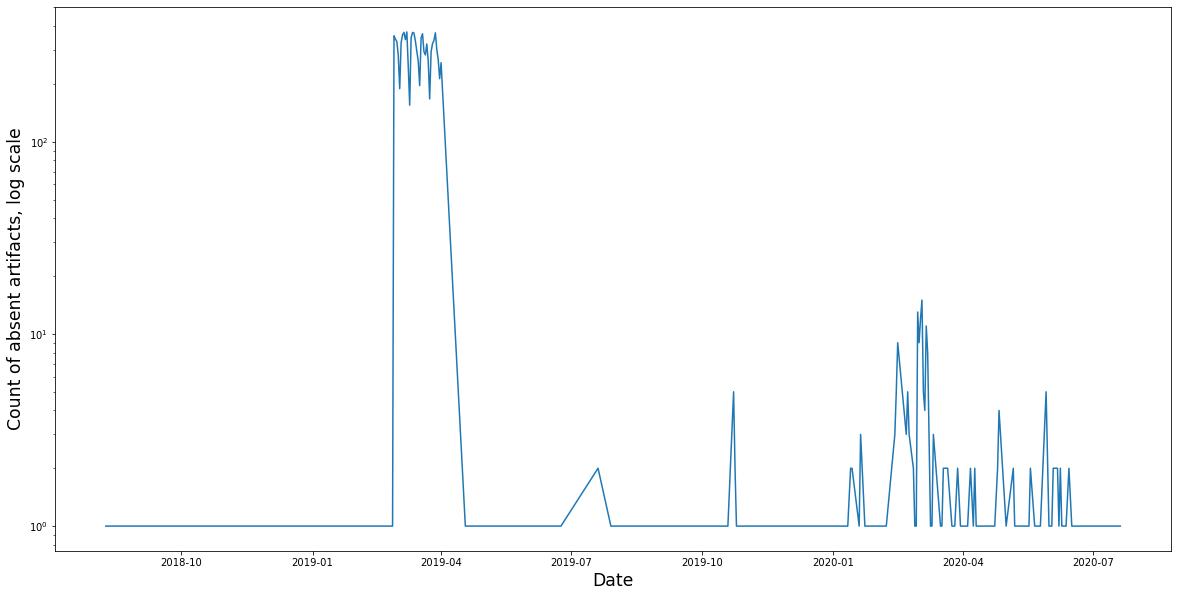

In [188]:
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.xlabel('Date', **{'fontsize': 'xx-large'})
plt.ylabel('Count of absent artifacts, log scale', **{'fontsize': 'xx-large'})
absent_dates.value_counts().plot()

By the way, how many artifacts are absent before we started the work
 on this ticket?

In [179]:
absent_values.count()


site_published_date         10485
s3_object_published_date        0
timedelta                       0
dtype: int64